
Нахождение оптимальных k для каждого frequency:
  Frequency = 5.0: Optimal k = 1.021300
  Frequency = 10.0: Optimal k = 0.957800
  Frequency = 16.0: Optimal k = 0.950000
  Frequency = 25.0: Optimal k = 0.953400
  Frequency = 32.0: Optimal k = 0.986900

Построение различных моделей зависимости k от frequency...


C:\Users\VKosinov\AppData\Local\Temp\ipykernel_8548\4170355657.py:308: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax9.boxplot(residuals_data, labels=model_names, patch_artist=True)


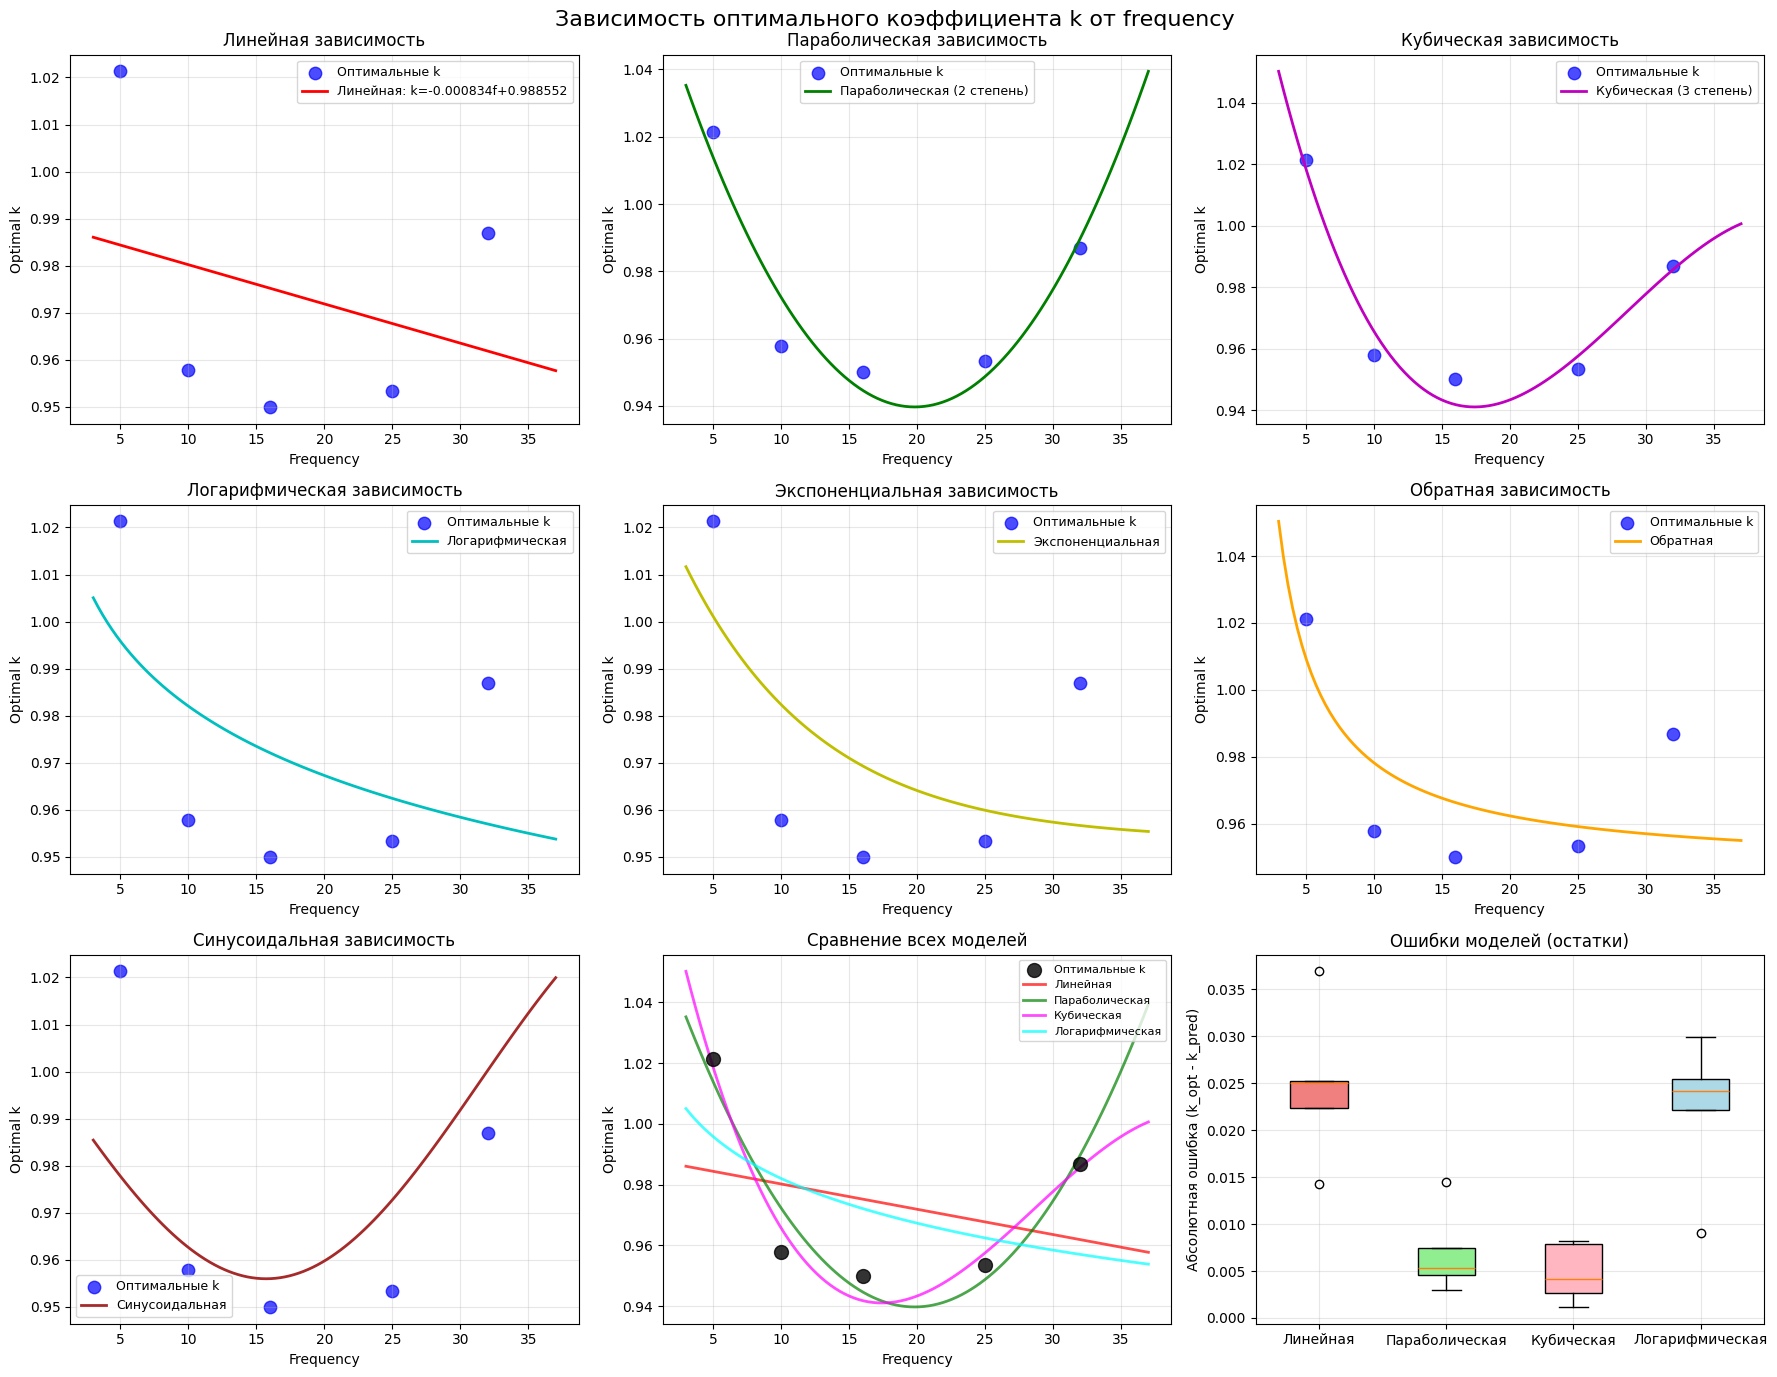


Проверка моделей на всем датасете...


C:\Users\VKosinov\AppData\Local\Temp\ipykernel_8548\4170355657.py:448: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax5.boxplot(all_errors, labels=model_names_box, patch_artist=True)


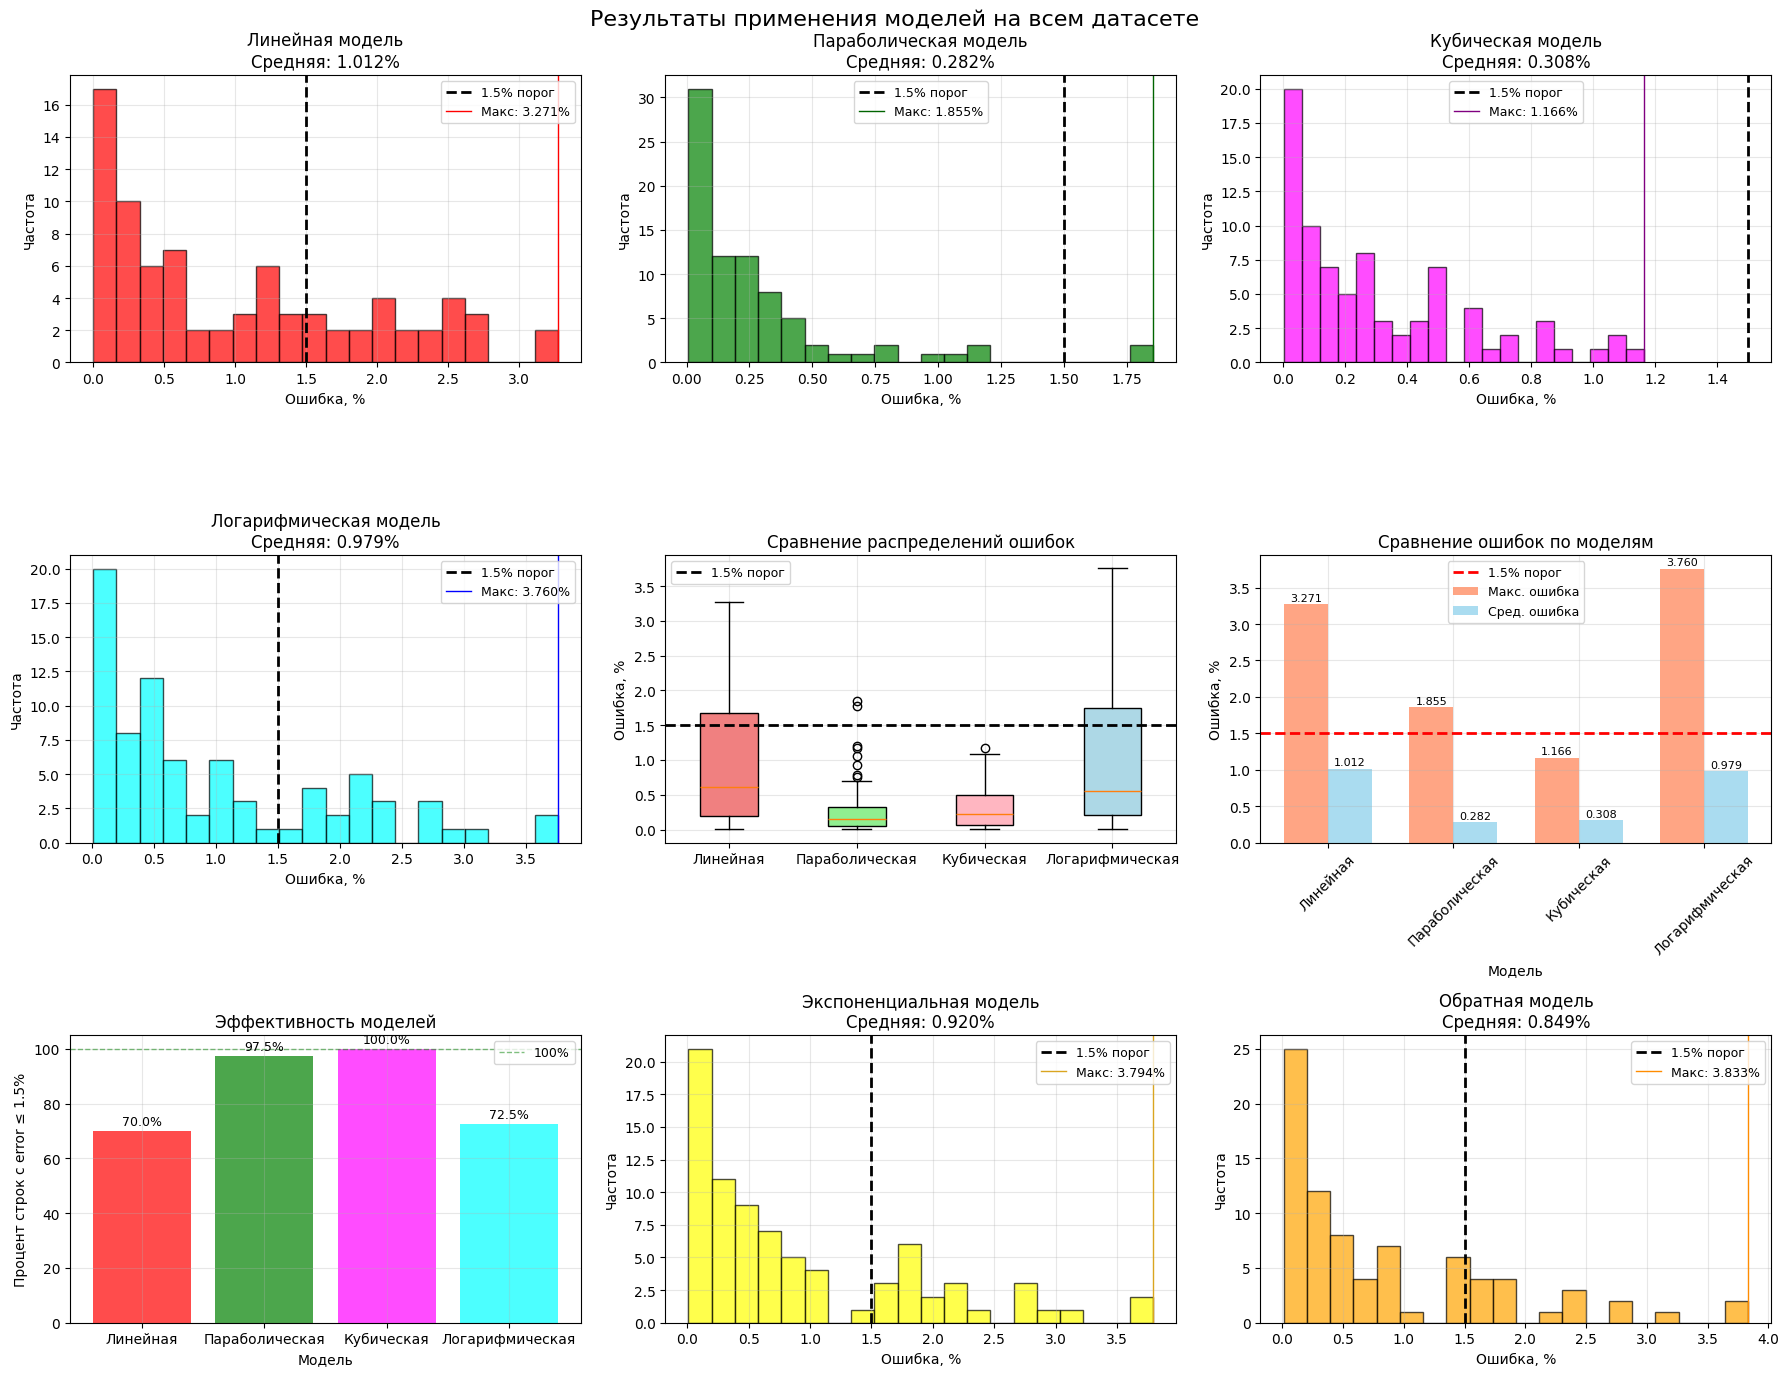


Результаты моделей:
Модель          Макс. ошибка Сред. ошибка ≤1.5% строк 
------------------------------------------------------------
Линейная        3.270682     1.011704     70.0        %
Параболическая  1.854787     0.282491     97.5        %
Кубическая      1.165515     0.308160     100.0       %
Логарифмическая 3.760239     0.978643     72.5        %

Лучшая модель: Кубическая
Максимальная ошибка: 1.165515%

Уравнение кубической модели:
k = -0.0000109176·f³ + 0.0009392559·f² + -0.0227732620·f + 1.1104183552


C:\Users\VKosinov\AppData\Local\Temp\ipykernel_8548\4170355657.py:671: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(boxplot_data, labels=labels, patch_artist=True)


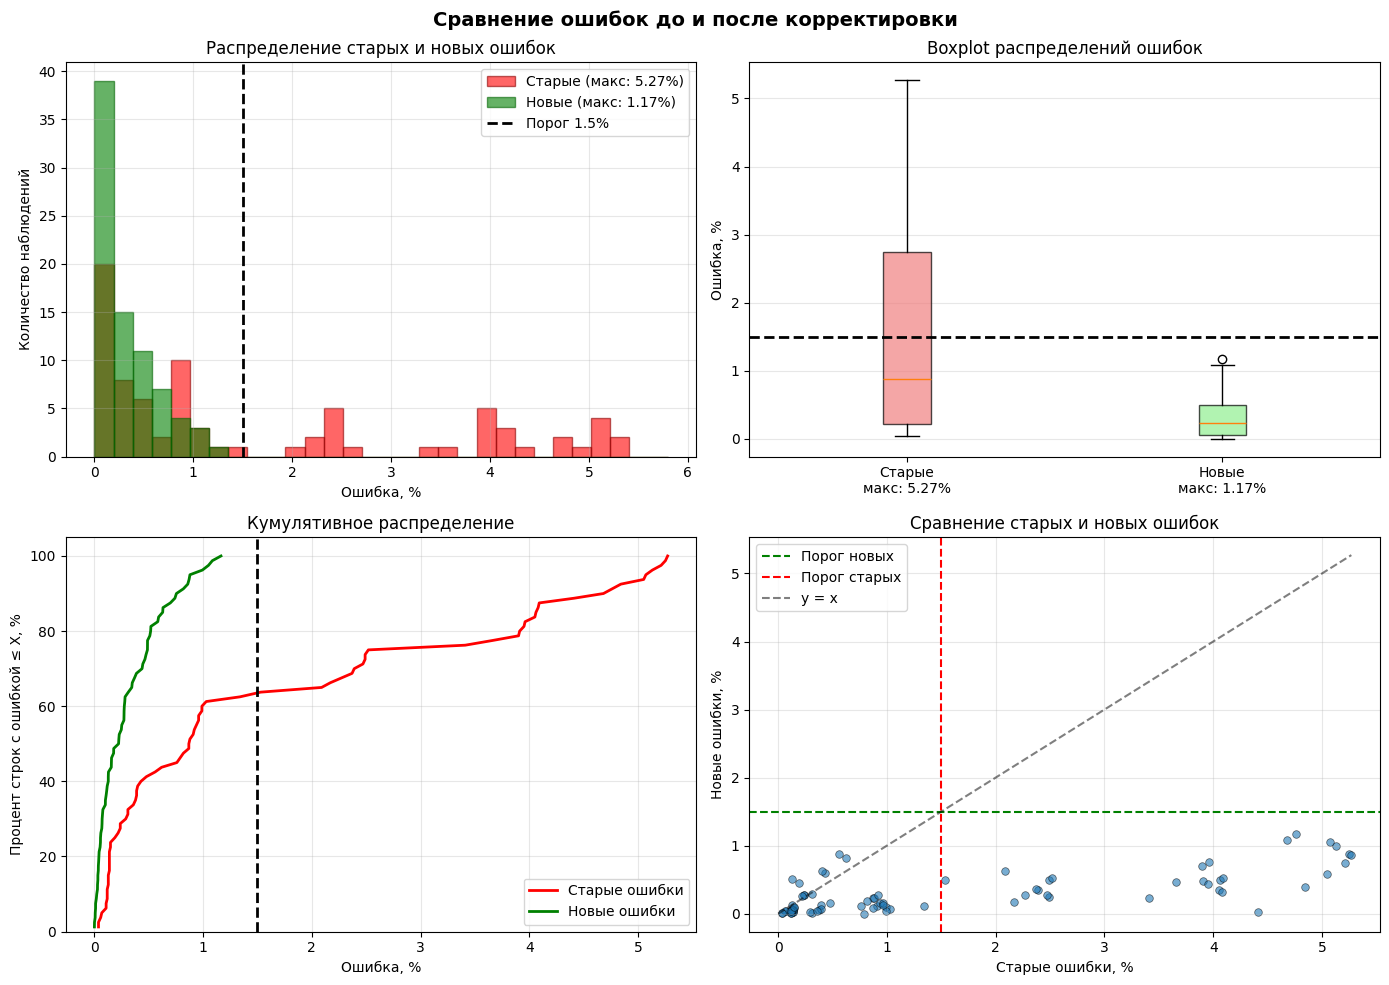


РЕЗЮМЕ АНАЛИЗА

Старые ошибки:
  Максимальная: 5.2700%
  Средняя: 1.6694%
  ≤1.5%: 50/80 (62.5%)

Новые ошибки:
  Максимальная: 1.1655%
  Средняя: 0.3082%
  ≤1.5%: 80/80 (100.0%)

Улучшение:
  Снижение максимальной ошибки: 4.1045%
  Увеличение строк ≤1.5%: +30 строк


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import os
import glob

# ========== 1. ОБРАБОТКА ДАННЫХ ==========
# Путь к папке с данными
folder_path = r'C:\Users\VKosinov\Desktop\GitHub\work\acceleration_error\data_X'

# Находим все CSV файлы в папке (кроме final.csv)
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
csv_files = [f for f in csv_files if "final.csv" not in f.lower()]

#print(f"Найдено {len(csv_files)} CSV файлов для обработки")

# Функция для форматирования чисел
def format_number(x):
    try:
        return f"{float(x):.1f}".replace('.', ',')
    except:
        return x

# Обрабатываем каждый файл
all_mean_rows = []
for i, file_path in enumerate(csv_files, 1):
    filename = os.path.basename(file_path)
    #print(f"\nОбработка файла {i}/{len(csv_files)}: {filename}")
    
    try:
        # Читаем данные
        df = pd.read_csv(file_path, delimiter=';',
                        names=['t', 'acceleration', 'frequency', 'boost', 'sensor'],
                        encoding='cp1251')
        
        # Удаляем столбец 't'
        df = df.drop(columns=['t'])
        
        # Применяем форматирование
        df['boost'] = df['boost'].apply(format_number)
        for col in ['acceleration', 'frequency', 'sensor']:
            df[col] = df[col].astype(str).str.replace('.', ',', regex=False)
        
        # Удаляем строки с нулевыми значениями acceleration
        df['acceleration_num'] = df['acceleration'].str.replace(',', '.').astype(float)
        df = df[df['acceleration_num'] != 0]
        
        # Удаляем выбросы по IQR
        if len(df) > 0:
            Q1 = df['acceleration_num'].quantile(0.25)
            Q3 = df['acceleration_num'].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            df_clean = df[(df['acceleration_num'] >= lower_bound) & 
                         (df['acceleration_num'] <= upper_bound)].copy()
            
            # Создаем строку со средним значением
            if len(df_clean) > 0:
                mean_acceleration = df_clean['acceleration_num'].mean()
                mean_row = pd.DataFrame({
                    'acceleration': [f"{mean_acceleration:.10f}".replace('.', ',')],
                    'frequency': [df_clean['frequency'].iloc[0]],
                    'boost': [df_clean['boost'].iloc[0]],
                    'sensor': [df_clean['sensor'].iloc[0]],
                    'source_file': [filename]
                })
                all_mean_rows.append(mean_row)
                
    except Exception as e:
        print(f"Ошибка при обработке файла {filename}: {e}")

# Сохраняем все строки со средними значениями
if all_mean_rows:
    final_df = pd.concat(all_mean_rows, ignore_index=True).dropna()
    output_path = os.path.join(folder_path, "final.csv")
    final_df.to_csv(output_path, sep=';', index=False, encoding='cp1251')
    #print(f"\nИтоговый файл сохранен: {output_path} ({len(final_df)} строк)")
else:
    print("\nНе удалось обработать ни один файл!")
    exit()

# ========== 2. ПРЕОБРАЗОВАНИЕ ИМЕН ФАЙЛОВ ==========
final_path = os.path.join(folder_path, "final.csv")
df = pd.read_csv(final_path, delimiter=';', encoding='cp1251')

# Функция для замены названия файла на букву
def replace_filename(filename):
    if isinstance(filename, str):
        if "-s " in filename.lower() or "s " in filename.lower() and "x " not in filename.lower():
            return "S"
        elif "-x " in filename.lower() or "x " in filename.lower() and "s " not in filename.lower():
            return "X"
    return filename

df['source_file'] = df['source_file'].apply(replace_filename)

# ========== 3. ДОБАВЛЕНИЕ СТОЛБЦА ОШИБКИ ==========
def convert_to_float(value):
    if isinstance(value, str):
        return float(value.replace(',', '.'))
    return float(value)

df['acceleration_num'] = df['acceleration'].apply(convert_to_float)
df['boost_num'] = df['boost'].apply(convert_to_float)
df['error_%'] = abs(df['boost_num'] - df['acceleration_num']) / 5.6 * 100
df['error_%'] = df['error_%'].round(2).astype(str).str.replace('.', ',')

df = df.drop(['acceleration_num', 'boost_num'], axis=1)
df.to_csv(final_path, sep=';', index=False, encoding='cp1251')

# ========== 4. ПОСТРОЕНИЕ МОДЕЛИ ДЛЯ OPTIMAL_K ==========
# Преобразуем в числа для анализа
df_numeric = df.copy()
for col in ['acceleration', 'frequency', 'boost', 'error_%']:
    df_numeric[col] = df_numeric[col].astype(str).str.replace(',', '.').astype(float)

# Находим оптимальные k для каждого frequency
freq_values = sorted(df_numeric['frequency'].unique())
optimal_k_by_freq = {}

print("\n" + "="*60)
print("Нахождение оптимальных k для каждого frequency:")
print("="*60)
for freq_val in freq_values:
    freq_df = df_numeric[df_numeric['frequency'] == freq_val]
    k_values = np.linspace(0.95, 1.05, 1001)
    best_k = 1.0
    min_max_error = float('inf')
    
    for k in k_values:
        errors = abs(freq_df['boost'] - k * freq_df['acceleration']) / 5.6 * 100
        max_error = errors.max()
        if max_error < min_max_error:
            min_max_error = max_error
            best_k = k
    
    optimal_k_by_freq[freq_val] = best_k
    print(f"  Frequency = {freq_val}: Optimal k = {best_k:.6f}")

# Подготавливаем данные для регрессии
freq_list = np.array(list(optimal_k_by_freq.keys()))
k_list = np.array(list(optimal_k_by_freq.values()))

# ========== 5. ГРАФИКИ РАЗЛИЧНЫХ МОДЕЛЕЙ ЗАВИСИМОСТИ K ОТ FREQUENCY ==========
print("\n" + "="*60)
print("Построение различных моделей зависимости k от frequency...")
print("="*60)
fig = plt.figure(figsize=(18, 14))

# 5.1 Линейная модель
ax1 = plt.subplot(3, 3, 1)
X_freq = freq_list.reshape(-1, 1)
model_linear = LinearRegression()
model_linear.fit(X_freq, k_list)

ax1.scatter(freq_list, k_list, s=80, color='blue', alpha=0.7, label='Оптимальные k')
x_fit = np.linspace(min(freq_list)-2, max(freq_list)+5, 100).reshape(-1, 1)
ax1.plot(x_fit, model_linear.predict(x_fit), 'r-', linewidth=2, 
        label=f'Линейная: k={model_linear.coef_[0]:.6f}f+{model_linear.intercept_:.6f}')
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Optimal k')
ax1.set_title('Линейная зависимость')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# 5.2 Параболическая (квадратичная) модель
ax2 = plt.subplot(3, 3, 2)
poly2 = PolynomialFeatures(degree=2)
X_poly2 = poly2.fit_transform(X_freq)
model_poly2 = LinearRegression()
model_poly2.fit(X_poly2, k_list)

x_fit_poly2 = poly2.transform(x_fit)
ax2.scatter(freq_list, k_list, s=80, color='blue', alpha=0.7, label='Оптимальные k')
ax2.plot(x_fit, model_poly2.predict(x_fit_poly2), 'g-', linewidth=2, 
        label='Параболическая (2 степень)')
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Optimal k')
ax2.set_title('Параболическая зависимость')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# 5.3 Кубическая модель
ax3 = plt.subplot(3, 3, 3)
poly3 = PolynomialFeatures(degree=3)
X_poly3 = poly3.fit_transform(X_freq)
model_poly3 = LinearRegression()
model_poly3.fit(X_poly3, k_list)

x_fit_poly3 = poly3.transform(x_fit)
ax3.scatter(freq_list, k_list, s=80, color='blue', alpha=0.7, label='Оптимальные k')
ax3.plot(x_fit, model_poly3.predict(x_fit_poly3), 'm-', linewidth=2, 
        label='Кубическая (3 степень)')
ax3.set_xlabel('Frequency')
ax3.set_ylabel('Optimal k')
ax3.set_title('Кубическая зависимость')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# 5.4 Логарифмическая модель
ax4 = plt.subplot(3, 3, 4)
X_log = np.log(X_freq + 1)  # +1 чтобы избежать log(0)
model_log = LinearRegression()
model_log.fit(X_log, k_list)

x_fit_log = np.log(x_fit + 1)
ax4.scatter(freq_list, k_list, s=80, color='blue', alpha=0.7, label='Оптимальные k')
ax4.plot(x_fit, model_log.predict(x_fit_log), 'c-', linewidth=2, 
        label='Логарифмическая')
ax4.set_xlabel('Frequency')
ax4.set_ylabel('Optimal k')
ax4.set_title('Логарифмическая зависимость')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

# 5.5 Экспоненциальная модель
ax5 = plt.subplot(3, 3, 5)
model_exp = LinearRegression()
X_exp = np.exp(-X_freq/10)  # масштабируем для устойчивости
model_exp.fit(X_exp, k_list)

x_fit_exp = np.exp(-x_fit/10)
ax5.scatter(freq_list, k_list, s=80, color='blue', alpha=0.7, label='Оптимальные k')
ax5.plot(x_fit, model_exp.predict(x_fit_exp), 'y-', linewidth=2, 
        label='Экспоненциальная')
ax5.set_xlabel('Frequency')
ax5.set_ylabel('Optimal k')
ax5.set_title('Экспоненциальная зависимость')
ax5.legend(fontsize=9)
ax5.grid(True, alpha=0.3)

# 5.6 Обратная зависимость
ax6 = plt.subplot(3, 3, 6)
X_inv = 1/(X_freq + 0.1)  # +0.1 чтобы избежать деления на 0
model_inv = LinearRegression()
model_inv.fit(X_inv, k_list)

x_fit_inv = 1/(x_fit + 0.1)
ax6.scatter(freq_list, k_list, s=80, color='blue', alpha=0.7, label='Оптимальные k')
ax6.plot(x_fit, model_inv.predict(x_fit_inv), 'orange', linewidth=2, 
        label='Обратная')
ax6.set_xlabel('Frequency')
ax6.set_ylabel('Optimal k')
ax6.set_title('Обратная зависимость')
ax6.legend(fontsize=9)
ax6.grid(True, alpha=0.3)

# 5.7 Синусоидальная модель (гипотетическая)
ax7 = plt.subplot(3, 3, 7)
X_sin = np.sin(X_freq/10)  # масштабируем частоту
model_sin = LinearRegression()
model_sin.fit(X_sin, k_list)

x_fit_sin = np.sin(x_fit/10)
ax7.scatter(freq_list, k_list, s=80, color='blue', alpha=0.7, label='Оптимальные k')
ax7.plot(x_fit, model_sin.predict(x_fit_sin), 'brown', linewidth=2, 
        label='Синусоидальная')
ax7.set_xlabel('Frequency')
ax7.set_ylabel('Optimal k')
ax7.set_title('Синусоидальная зависимость')
ax7.legend(fontsize=9)
ax7.grid(True, alpha=0.3)

# 5.8 Все модели вместе
ax8 = plt.subplot(3, 3, 8)
ax8.scatter(freq_list, k_list, s=100, color='black', alpha=0.8, label='Оптимальные k', zorder=5)

models = [
    ('Линейная', model_linear.predict(x_fit), 'red'),
    ('Параболическая', model_poly2.predict(x_fit_poly2), 'green'),
    ('Кубическая', model_poly3.predict(x_fit_poly3), 'magenta'),
    ('Логарифмическая', model_log.predict(x_fit_log), 'cyan'),
]

for name, y_pred, color in models:
    ax8.plot(x_fit, y_pred, color=color, linewidth=2, alpha=0.7, label=name)

ax8.set_xlabel('Frequency')
ax8.set_ylabel('Optimal k')
ax8.set_title('Сравнение всех моделей')
ax8.legend(fontsize=8, loc='upper right')
ax8.grid(True, alpha=0.3)

# 5.9 Остатки моделей
ax9 = plt.subplot(3, 3, 9)
model_names = ['Линейная', 'Параболическая', 'Кубическая', 'Логарифмическая']
model_functions = [
    lambda f: model_linear.predict([[f]])[0],
    lambda f: model_poly2.predict(poly2.transform([[f]]))[0],
    lambda f: model_poly3.predict(poly3.transform([[f]]))[0],
    lambda f: model_log.predict([[np.log(f + 1)]])[0],
]

residuals_data = []
for i, (name, func) in enumerate(zip(model_names, model_functions)):
    residuals = []
    for f_val, k_opt in zip(freq_list, k_list):
        k_pred = func(f_val)
        residuals.append(abs(k_opt - k_pred))
    residuals_data.append(residuals)

bp = ax9.boxplot(residuals_data, labels=model_names, patch_artist=True)
colors = ['lightcoral', 'lightgreen', 'lightpink', 'lightblue']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax9.set_ylabel('Абсолютная ошибка (k_opt - k_pred)')
ax9.set_title('Ошибки моделей (остатки)')
ax9.grid(True, alpha=0.3)

plt.suptitle('Зависимость оптимального коэффициента k от frequency', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

# ========== 6. ПРОВЕРКА МОДЕЛЕЙ НА ВСЕМ ДАТАСЕТЕ ==========
print("\n" + "="*60)
print("Проверка моделей на всем датасете...")
print("="*60)

fig2 = plt.figure(figsize=(18, 14))

# Функции для вычисления k по моделям
def k_linear_model(f):
    return model_linear.predict([[f]])[0]

def k_parabola_model(f):
    return model_poly2.predict(poly2.transform([[f]]))[0]

def k_cubic_model(f):
    return model_poly3.predict(poly3.transform([[f]]))[0]

def k_log_model(f):
    return model_log.predict([[np.log(f + 1)]])[0]

def k_exp_model(f):
    return model_exp.predict([[np.exp(-f/10)]])[0]

def k_inv_model(f):
    return model_inv.predict([[1/(f + 0.1)]])[0]

def k_sin_model(f):
    return model_sin.predict([[np.sin(f/10)]])[0]

# 6.1 Ошибки для линейной модели
ax1 = plt.subplot(3, 3, 1)
errors_linear = []
for idx, row in df_numeric.iterrows():
    freq_val = row['frequency']
    boost_val = row['boost']
    acc_val = row['acceleration']
    
    k = k_linear_model(freq_val)
    error = abs(boost_val - k * acc_val) / 5.6 * 100
    errors_linear.append(error)

errors_linear = np.array(errors_linear)
ax1.hist(errors_linear, bins=20, alpha=0.7, color='red', edgecolor='black')
ax1.axvline(x=1.5, color='black', linestyle='--', linewidth=2, label='1.5% порог')
ax1.axvline(x=errors_linear.max(), color='red', linestyle='-', linewidth=1, 
           label=f'Макс: {errors_linear.max():.3f}%')
ax1.set_xlabel('Ошибка, %')
ax1.set_ylabel('Частота')
ax1.set_title(f'Линейная модель\nСредняя: {errors_linear.mean():.3f}%')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# 6.2 Ошибки для параболической модели
ax2 = plt.subplot(3, 3, 2)
errors_parabola = []
for idx, row in df_numeric.iterrows():
    freq_val = row['frequency']
    boost_val = row['boost']
    acc_val = row['acceleration']
    
    k = k_parabola_model(freq_val)
    error = abs(boost_val - k * acc_val) / 5.6 * 100
    errors_parabola.append(error)

errors_parabola = np.array(errors_parabola)
ax2.hist(errors_parabola, bins=20, alpha=0.7, color='green', edgecolor='black')
ax2.axvline(x=1.5, color='black', linestyle='--', linewidth=2, label='1.5% порог')
ax2.axvline(x=errors_parabola.max(), color='darkgreen', linestyle='-', linewidth=1, 
           label=f'Макс: {errors_parabola.max():.3f}%')
ax2.set_xlabel('Ошибка, %')
ax2.set_ylabel('Частота')
ax2.set_title(f'Параболическая модель\nСредняя: {errors_parabola.mean():.3f}%')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# 6.3 Ошибки для кубической модели
ax3 = plt.subplot(3, 3, 3)
errors_cubic = []
for idx, row in df_numeric.iterrows():
    freq_val = row['frequency']
    boost_val = row['boost']
    acc_val = row['acceleration']
    
    k = k_cubic_model(freq_val)
    error = abs(boost_val - k * acc_val) / 5.6 * 100
    errors_cubic.append(error)

errors_cubic = np.array(errors_cubic)
ax3.hist(errors_cubic, bins=20, alpha=0.7, color='magenta', edgecolor='black')
ax3.axvline(x=1.5, color='black', linestyle='--', linewidth=2, label='1.5% порог')
ax3.axvline(x=errors_cubic.max(), color='purple', linestyle='-', linewidth=1, 
           label=f'Макс: {errors_cubic.max():.3f}%')
ax3.set_xlabel('Ошибка, %')
ax3.set_ylabel('Частота')
ax3.set_title(f'Кубическая модель\nСредняя: {errors_cubic.mean():.3f}%')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# 6.4 Ошибки для логарифмической модели
ax4 = plt.subplot(3, 3, 4)
errors_log = []
for idx, row in df_numeric.iterrows():
    freq_val = row['frequency']
    boost_val = row['boost']
    acc_val = row['acceleration']
    
    k = k_log_model(freq_val)
    error = abs(boost_val - k * acc_val) / 5.6 * 100
    errors_log.append(error)

errors_log = np.array(errors_log)
ax4.hist(errors_log, bins=20, alpha=0.7, color='cyan', edgecolor='black')
ax4.axvline(x=1.5, color='black', linestyle='--', linewidth=2, label='1.5% порог')
ax4.axvline(x=errors_log.max(), color='blue', linestyle='-', linewidth=1, 
           label=f'Макс: {errors_log.max():.3f}%')
ax4.set_xlabel('Ошибка, %')
ax4.set_ylabel('Частота')
ax4.set_title(f'Логарифмическая модель\nСредняя: {errors_log.mean():.3f}%')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

# 6.5 Сравнение всех моделей (boxplot)
ax5 = plt.subplot(3, 3, 5)
all_errors = [errors_linear, errors_parabola, errors_cubic, errors_log]
model_names_box = ['Линейная', 'Параболическая', 'Кубическая', 'Логарифмическая']
colors_box = ['lightcoral', 'lightgreen', 'lightpink', 'lightblue']

bp = ax5.boxplot(all_errors, labels=model_names_box, patch_artist=True)
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)

ax5.axhline(y=1.5, color='black', linestyle='--', linewidth=2, label='1.5% порог')
ax5.set_ylabel('Ошибка, %')
ax5.set_title('Сравнение распределений ошибок')
ax5.legend(fontsize=9)
ax5.grid(True, alpha=0.3)

# 6.6 Максимальные ошибки по моделям
ax6 = plt.subplot(3, 3, 6)
max_errors = [errors_linear.max(), errors_parabola.max(), errors_cubic.max(), errors_log.max()]
mean_errors = [errors_linear.mean(), errors_parabola.mean(), errors_cubic.mean(), errors_log.mean()]

x_pos = np.arange(len(model_names_box))
width = 0.35

bars1 = ax6.bar(x_pos - width/2, max_errors, width, label='Макс. ошибка', 
               color='coral', alpha=0.7)
bars2 = ax6.bar(x_pos + width/2, mean_errors, width, label='Сред. ошибка', 
               color='skyblue', alpha=0.7)

ax6.axhline(y=1.5, color='red', linestyle='--', linewidth=2, label='1.5% порог')
ax6.set_xlabel('Модель')
ax6.set_ylabel('Ошибка, %')
ax6.set_title('Сравнение ошибок по моделям')
ax6.set_xticks(x_pos)
ax6.set_xticklabels(model_names_box, rotation=45)
ax6.legend(fontsize=9)

# Добавляем значения на столбцы
for bar in bars1:
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{height:.3f}', ha='center', va='bottom', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{height:.3f}', ha='center', va='bottom', fontsize=8)

ax6.grid(True, alpha=0.3)

# 6.7 Процент строк с ошибкой ≤ 1.5%
ax7 = plt.subplot(3, 3, 7)
below_threshold = [
    (errors_linear <= 1.5).sum() / len(errors_linear) * 100,
    (errors_parabola <= 1.5).sum() / len(errors_parabola) * 100,
    (errors_cubic <= 1.5).sum() / len(errors_cubic) * 100,
    (errors_log <= 1.5).sum() / len(errors_log) * 100
]

bars = ax7.bar(model_names_box, below_threshold, color=['red', 'green', 'magenta', 'cyan'], alpha=0.7)
ax7.axhline(y=100, color='green', linestyle='--', linewidth=1, alpha=0.5, label='100%')
ax7.set_xlabel('Модель')
ax7.set_ylabel('Процент строк с error ≤ 1.5%')
ax7.set_title('Эффективность моделей')
ax7.set_ylim([0, 105])

# Добавляем значения на столбцы
for bar, value in zip(bars, below_threshold):
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{value:.1f}%', ha='center', va='bottom', fontsize=9)

ax7.legend(fontsize=9)
ax7.grid(True, alpha=0.3)

# 6.8 Ошибки экспоненциальной модели
ax8 = plt.subplot(3, 3, 8)
errors_exp = []
for idx, row in df_numeric.iterrows():
    freq_val = row['frequency']
    boost_val = row['boost']
    acc_val = row['acceleration']
    
    k = k_exp_model(freq_val)
    error = abs(boost_val - k * acc_val) / 5.6 * 100
    errors_exp.append(error)

errors_exp = np.array(errors_exp)
ax8.hist(errors_exp, bins=20, alpha=0.7, color='yellow', edgecolor='black')
ax8.axvline(x=1.5, color='black', linestyle='--', linewidth=2, label='1.5% порог')
ax8.axvline(x=errors_exp.max(), color='goldenrod', linestyle='-', linewidth=1, 
           label=f'Макс: {errors_exp.max():.3f}%')
ax8.set_xlabel('Ошибка, %')
ax8.set_ylabel('Частота')
ax8.set_title(f'Экспоненциальная модель\nСредняя: {errors_exp.mean():.3f}%')
ax8.legend(fontsize=9)
ax8.grid(True, alpha=0.3)

# 6.9 Ошибки обратной модели
ax9 = plt.subplot(3, 3, 9)
errors_inv = []
for idx, row in df_numeric.iterrows():
    freq_val = row['frequency']
    boost_val = row['boost']
    acc_val = row['acceleration']
    
    k = k_inv_model(freq_val)
    error = abs(boost_val - k * acc_val) / 5.6 * 100
    errors_inv.append(error)

errors_inv = np.array(errors_inv)
ax9.hist(errors_inv, bins=20, alpha=0.7, color='orange', edgecolor='black')
ax9.axvline(x=1.5, color='black', linestyle='--', linewidth=2, label='1.5% порог')
ax9.axvline(x=errors_inv.max(), color='darkorange', linestyle='-', linewidth=1, 
           label=f'Макс: {errors_inv.max():.3f}%')
ax9.set_xlabel('Ошибка, %')
ax9.set_ylabel('Частота')
ax9.set_title(f'Обратная модель\nСредняя: {errors_inv.mean():.3f}%')
ax9.legend(fontsize=9)
ax9.grid(True, alpha=0.3)

plt.suptitle('Результаты применения моделей на всем датасете', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

# ========== 7. ВЫБОР ЛУЧШЕЙ МОДЕЛИ И ДОБАВЛЕНИЕ В ФАЙЛ ==========
# Определяем лучшую модель по минимальной максимальной ошибке
model_errors_list = [errors_linear, errors_parabola, errors_cubic, errors_log]
model_max_errors = [err.max() for err in model_errors_list]
best_model_idx = np.argmin(model_max_errors)
best_model_name = model_names_box[best_model_idx]

print("\n" + "="*60)
print("Результаты моделей:")
print("="*60)
print(f"{'Модель':<15} {'Макс. ошибка':<12} {'Сред. ошибка':<12} {'≤1.5% строк':<12}")
print("-" * 60)

for i, name in enumerate(model_names_box):
    max_err = model_errors_list[i].max()
    mean_err = model_errors_list[i].mean()
    count_below = (model_errors_list[i] <= 1.5).sum()
    percent_below = count_below / len(df_numeric) * 100
    
    print(f"{name:<15} {max_err:<12.6f} {mean_err:<12.6f} {percent_below:<12.1f}%")
print("\n" + "="*60)
print(f"Лучшая модель: {best_model_name}")
print("="*60)
print(f"Максимальная ошибка: {model_max_errors[best_model_idx]:.6f}%")

# Используем кубическую модель (как лучшую)
def k_cubic_formula(frequency):
    X_input = poly3.transform([[frequency]])
    return model_poly3.predict(X_input)[0]

# Добавляем столбцы в исходный DataFrame
df['Optimal_k'] = df_numeric['frequency'].apply(k_cubic_formula)
df['new_error_%'] = abs(df_numeric['boost'] - df['Optimal_k'] * df_numeric['acceleration']) / 5.6 * 100

# Форматируем числа
for col in ['Optimal_k', 'new_error_%']:
    df[col] = df[col].astype(str).str.replace('.', ',', regex=False)

# Сохраняем обновленный файл
df.to_csv(final_path, sep=';', index=False, encoding='cp1251')
#print(f"\nФайл обновлен с Optimal_k и new_error_%: {final_path}")

# Выводим уравнение кубической модели
coefficients = model_poly3.coef_
intercept = model_poly3.intercept_
print("\n" + "="*60)
print("Уравнение кубической модели:")
print("=" * 60)
print(f"k = {coefficients[3]:.10f}·f³ + {coefficients[2]:.10f}·f² + {coefficients[1]:.10f}·f + {intercept:.10f}")

# ========== 8. АНАЛИЗ И ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ==========
# Преобразуем все числовые столбцы для анализа
for col in df.columns:
    if col not in ['sensor', 'source_file']:
        try:
            df[col] = df[col].astype(str).str.replace(',', '.').astype(float)
        except:
            pass

# Статистика ошибок
old_errors = df['error_%'].values
new_errors = df['new_error_%'].values

stats_old = {
    'max': float(old_errors.max()),
    'mean': float(old_errors.mean()),
    'median': float(np.median(old_errors)),
    'below_15': int((old_errors <= 1.5).sum()),
    'total': len(old_errors)
}

stats_new = {
    'max': float(new_errors.max()),
    'mean': float(new_errors.mean()),
    'median': float(np.median(new_errors)),
    'below_15': int((new_errors <= 1.5).sum()),
    'total': len(new_errors)
}

# Основной график сравнения
plt.figure(figsize=(14, 10))

# 1. Гистограммы
plt.subplot(2, 2, 1)
bins = 30
max_error_val = max(stats_old['max'], stats_new['max'])
bins_range = np.linspace(0, max_error_val * 1.1, bins + 1)

plt.hist(old_errors, bins=bins_range, alpha=0.6, color='red', 
         label=f'Старые (макс: {stats_old["max"]:.2f}%)', edgecolor='darkred')
plt.hist(new_errors, bins=bins_range, alpha=0.6, color='green', 
         label=f'Новые (макс: {stats_new["max"]:.2f}%)', edgecolor='darkgreen')
plt.axvline(x=1.5, color='black', linestyle='--', linewidth=2, label='Порог 1.5%')
plt.xlabel('Ошибка, %')
plt.ylabel('Количество наблюдений')
plt.title('Распределение старых и новых ошибок')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Boxplot
plt.subplot(2, 2, 2)
boxplot_data = [old_errors, new_errors]
labels = [f'Старые\nмакс: {stats_old["max"]:.2f}%', f'Новые\nмакс: {stats_new["max"]:.2f}%']

bp = plt.boxplot(boxplot_data, labels=labels, patch_artist=True)
colors_box = ['lightcoral', 'lightgreen']
for i, box in enumerate(bp['boxes']):
    box.set(facecolor=colors_box[i], alpha=0.7)
plt.axhline(y=1.5, color='black', linestyle='--', linewidth=2)
plt.ylabel('Ошибка, %')
plt.title('Boxplot распределений ошибок')
plt.grid(True, alpha=0.3, axis='y')

# 3. Кумулятивное распределение
plt.subplot(2, 2, 3)
sorted_old = np.sort(old_errors)
sorted_new = np.sort(new_errors)
cumulative_old = np.arange(1, len(sorted_old) + 1) / len(sorted_old) * 100
cumulative_new = np.arange(1, len(sorted_new) + 1) / len(sorted_new) * 100

plt.plot(sorted_old, cumulative_old, 'r-', linewidth=2, label='Старые ошибки')
plt.plot(sorted_new, cumulative_new, 'g-', linewidth=2, label='Новые ошибки')
plt.axvline(x=1.5, color='black', linestyle='--', linewidth=2)
plt.xlabel('Ошибка, %')
plt.ylabel('Процент строк с ошибкой ≤ X, %')
plt.title('Кумулятивное распределение')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim([0, 105])

# 4. Scatter plot сравнения
plt.subplot(2, 2, 4)
plt.scatter(old_errors, new_errors, alpha=0.6, s=30, edgecolor='black', linewidth=0.5)
plt.axhline(y=1.5, color='green', linestyle='--', linewidth=1.5, label='Порог новых')
plt.axvline(x=1.5, color='red', linestyle='--', linewidth=1.5, label='Порог старых')
plt.plot([0, max_error_val], [0, max_error_val], 'k--', alpha=0.5, label='y = x')
plt.xlabel('Старые ошибки, %')
plt.ylabel('Новые ошибки, %')
plt.title('Сравнение старых и новых ошибок')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.suptitle('Сравнение ошибок до и после корректировки', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Вывод результатов
print("\n" + "="*60)
print("РЕЗЮМЕ АНАЛИЗА")
print("="*60)
print(f"\nСтарые ошибки:")
print(f"  Максимальная: {stats_old['max']:.4f}%")
print(f"  Средняя: {stats_old['mean']:.4f}%")
print(f"  ≤1.5%: {stats_old['below_15']}/{stats_old['total']} ({stats_old['below_15']/stats_old['total']*100:.1f}%)")

print(f"\nНовые ошибки:")
print(f"  Максимальная: {stats_new['max']:.4f}%")
print(f"  Средняя: {stats_new['mean']:.4f}%")
print(f"  ≤1.5%: {stats_new['below_15']}/{stats_new['total']} ({stats_new['below_15']/stats_new['total']*100:.1f}%)")

print(f"\nУлучшение:")
print(f"  Снижение максимальной ошибки: {stats_old['max'] - stats_new['max']:.4f}%")
print(f"  Увеличение строк ≤1.5%: +{stats_new['below_15'] - stats_old['below_15']} строк")